# **Breast Cancer IDC Classification using Deep Learning**

This notebook describes the classification of breast histopathology images. The dataset was found on Kaggle : [Breast Histopathology Images ](https://www.kaggle.com/paultimothymooney/breast-histopathology-images). 

The original dataset consisted of 162 whole mount slide images of Breast Cancer (BCa) specimens scanned at 40x. From that, 277,524 patches of size 50 x 50 were extracted (198,738 IDC negative and 78,786 IDC positive). Each patch’s file name is of the format: uxXyYclassC.png — > example 10253idx5x1351y1101class0.png . Where u is the patient ID (10253idx5), X is the x-coordinate of where this patch was cropped from, Y is the y-coordinate of where this patch was cropped from, and C indicates the class where 0 is non-IDC and 1 is IDC.

Author : Rania Charkaoui 

## Imports

In [1]:
import tensorflow as tf
print(tf.__version__)
#physical_devices = tf.config.list_physical_devices('GPU') 
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

2.4.0-rc0


In [13]:
import os
from glob import glob
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import itertools
from skimage import exposure
from skimage.io import imread
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import keras
from keras import backend as K
from keras import metrics
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json, Model
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Input, Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D,GlobalMaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input, VGG16
from tensorflow.keras.applications.densenet import preprocess_input, DenseNet121
from tensorflow.python.keras.layers import ZeroPadding2D
from collections import defaultdict
import visualkeras
from keras.preprocessing.image import ImageDataGenerator
from io import BytesIO
from PIL import Image

from tensorflow.keras.preprocessing import image
from PIL import Image

%matplotlib inline

## Data Preparation

In this section, the data is formatted into a Pandas DataFrame that has 4 columns : filename, patient id, x-coordinate and y-coordinate. The imbalance in the dataset is also adjusted to avoid a biaised model.

In [3]:
print(os.getcwd())
# os.chdir("data")
print(os.listdir("data/"))

/Users/raniacharkaoui/Desktop/MA1/idc_in_breast_cancer
['9036', '10268', '10257', '8913', '13613', '8914', '15510', '10259', '16165', '10292', '12951', '10261', '10295', '9259', '12750', '13020', '16552', '12905', '9266', '16555', '13018', '9261', '9257', '12934', '12933', '9250', '10260', '10258', '10293', '9037', '10269', '16531', '10256', '15516', '12932', '12935', '9256', '16554', '9260', '13019', '16553', '13021', '8984', '9258', '12751', '9267', '12876', '12882', '15634', '12871', '14188', '15633', '9324', '12878', '.DS_Store', '9323', '9383', '8867', '9346', '9174', '12822', '9173', '9322', '9325', '12879', '14189', '12870', '12884', '12241', '15632', '12883', '12877', '9126', '13106', '12823', '13591', '9175', '12824', '9347', '9181', '9382', '10307', '13916', '10300', '14306', '15471', '16896', '14156', '9135', '12890', '12897', '10308', '10301', '10306', '12896', '14157', '12891', '12898', '14192', '13458', '9083', '9077', '13460', '8955', '12910', '9041', '14210', 'IDC_regul

Our histopathology images are put in a Pandas dataframe with the following colums: filename, patient's id, x-coordinate of the entire slide, y-coordinate and class.

In [4]:
data = []

for n in os.listdir("data/"):
    if n != "DeepLearning_BreastCancer.ipynb" and n != ".DS_Store" and n != ".ipynb_checkpoints" and n !='IDC_regular_ps50_idx5':
        for d in os.listdir("data/" + n): #0 or 1
            if d != ".DS_Store":
                for f in os.listdir("data/" + n + "/" +str(d)+"/"): #png file
                    data.append("data/{}/{}/{}".format(n,d,f))

print(len(data))
print(data[:10])

277524
['data/9036/0/9036_idx5_x1051_y2401_class0.png', 'data/9036/0/9036_idx5_x2951_y951_class0.png', 'data/9036/0/9036_idx5_x3001_y1451_class0.png', 'data/9036/0/9036_idx5_x3051_y801_class0.png', 'data/9036/0/9036_idx5_x951_y1901_class0.png', 'data/9036/0/9036_idx5_x2251_y751_class0.png', 'data/9036/0/9036_idx5_x1901_y401_class0.png', 'data/9036/0/9036_idx5_x3201_y1101_class0.png', 'data/9036/0/9036_idx5_x3351_y1251_class0.png', 'data/9036/0/9036_idx5_x2051_y2551_class0.png']


In [5]:
f = pd.Series(data)
# print(f[:10])
i = f.apply(lambda x: x.split("_")[0].split("/")[3]).astype('int')
# print(i[:10])
x = f.apply(lambda x: x.split("_")[2][1:]).astype('int')
# print(x[:10])
y = f.apply(lambda x: x.split("_")[3][1:]).astype('int')
# print(y[:10])
c = f.apply(lambda x: x.split("_")[4][5]).astype('str')
# print(c[:10])
# print(len(f))
df = pd.DataFrame({'filename': f, 'id': i, 'x':x, 'y':y,'class':c})
print(df.head())

                                       filename    id     x     y class
0  data/9036/0/9036_idx5_x1051_y2401_class0.png  9036  1051  2401     0
1   data/9036/0/9036_idx5_x2951_y951_class0.png  9036  2951   951     0
2  data/9036/0/9036_idx5_x3001_y1451_class0.png  9036  3001  1451     0
3   data/9036/0/9036_idx5_x3051_y801_class0.png  9036  3051   801     0
4   data/9036/0/9036_idx5_x951_y1901_class0.png  9036   951  1901     0


Removing imbalance in data by downsampling

In [6]:
df_cut = df.copy()

imbalance = sum(df["class"]=='0') - sum(df["class"]=='1')

to_cut = df_cut.loc[df_cut["class"]=='0'].sample(n=imbalance)

df_cut = df_cut.loc[~df_cut["filename"].isin(to_cut["filename"])]
print(df_cut.head())
print(len(df_cut))

                                       filename    id     x     y class
0  data/9036/0/9036_idx5_x1051_y2401_class0.png  9036  1051  2401     0
1   data/9036/0/9036_idx5_x2951_y951_class0.png  9036  2951   951     0
2  data/9036/0/9036_idx5_x3001_y1451_class0.png  9036  3001  1451     0
6   data/9036/0/9036_idx5_x1901_y401_class0.png  9036  1901   401     0
7  data/9036/0/9036_idx5_x3201_y1101_class0.png  9036  3201  1101     0
157572


## Data Augmentation

70% training, 20% validation, and 10% testing split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df_cut["filename"], df_cut["class"], test_size=0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [7]:
df_train = pd.DataFrame({"filename":X_train, "class":y_train})
df_val = pd.DataFrame({"filename":X_val, "class":y_val})
df_test = pd.DataFrame({"filename":X_test, "class":y_test})

In [8]:
batch_size = 64
target_size = (50,50)

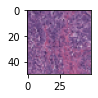

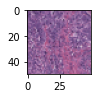

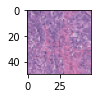

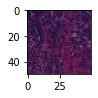

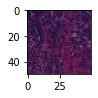

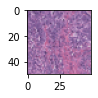

In [10]:
"""test code to see if the transformations used on the data are relevant on some samples"""

img_array= Image.open("data/15473/1/15473_idx5_x2301_y1751_class1.png")
#img_array= Image.open("data/9036/0/9036_idx5_x3051_y801_class0.png")

# dimesion adjustment
sam = expand_dims(img_array, 0)
# create image data augmentation generator

#imageDataGenerator_obj = ImageDataGenerator(brightness_range=[0.5,0.9])
#imageDataGenerator_obj = ImageDataGenerator(featurewise_center=True,
    #zca_whitening=True)
imageDataGenerator_obj = ImageDataGenerator(channel_shift_range=50.0)
#imageDataGenerator_obj = ImageDataGenerator(rotation_range=90)

# plotting the images
iterator = imageDataGenerator_obj.flow(sam, batch_size=1)
for j in range(6):
    plt.subplot(330 + 1 + j)
    chunk = iterator.next()
    sub_img = chunk[0].astype('uint8')
    plt.imshow(sub_img)
    plt.show()

ImageDataGenerator with a 90 degrees rotation

In [9]:
datagen = ImageDataGenerator(rescale=1./255, 
                             rotation_range=90)
datagen2 = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(dataframe=df_train, 
                                              directory=None, 
                                              x_col="filename", y_col="class", 
                                              class_mode="categorical", 
                                              target_size=target_size, batch_size=batch_size)

val_generator = datagen2.flow_from_dataframe(dataframe=df_val,
                                           directory=None, 
                                           x_col="filename", y_col="class", 
                                           class_mode="categorical", 
                                           target_size=target_size, batch_size=batch_size)

test_generator = datagen2.flow_from_dataframe(dataframe=df_test, 
                                            directory=None, 
                                            x_col="filename", y_col="class", 
                                            class_mode="categorical", 
                                            target_size=target_size, batch_size=batch_size, 
                                            shuffle=False)

Found 113451 validated image filenames belonging to 2 classes.
Found 28363 validated image filenames belonging to 2 classes.
Found 15758 validated image filenames belonging to 2 classes.


ImageDataGenerator with a 90 degrees rotation and ZCA whitening 

In [10]:
datagen_w = ImageDataGenerator(rescale=1./255, 
                               rotation_range=90,
                               featurewise_center=True,
                               zca_whitening=True)
                               
datagen2_w = ImageDataGenerator(rescale=1./255)

train_generator_w = datagen_w.flow_from_dataframe(dataframe=df_train, 
                                                  directory=None, 
                                                  x_col="filename", y_col="class", 
                                                  class_mode="categorical", 
                                                  target_size=target_size, batch_size=batch_size)
val_generator_w = datagen2_w.flow_from_dataframe(dataframe=df_val, 
                                                 directory=None, 
                                                 x_col="filename", y_col="class", 
                                                 class_mode="categorical", 
                                                 target_size=target_size, batch_size=batch_size)
test_generator_w = datagen2_w.flow_from_dataframe(dataframe=df_test, 
                                                  directory=None, 
                                                  x_col="filename", y_col="class", 
                                                  class_mode="categorical", 
                                                  target_size=target_size, batch_size=batch_size,
                                                  shuffle=False)

Found 113451 validated image filenames belonging to 2 classes.
Found 28363 validated image filenames belonging to 2 classes.
Found 15758 validated image filenames belonging to 2 classes.


ImageDataGenerator with horizontal and vertical flip and channel_shift_range

In [11]:
trainDataGen = ImageDataGenerator(rescale = 1./255,
                                 horizontal_flip = True,
                                 vertical_flip = True,channel_shift_range=50.0)
valDataGen = ImageDataGenerator(rescale = 1./255)

trainFlow = trainDataGen.flow_from_dataframe(df_train, x_col = 'filename', y_col = 'class', 
                                             class_mode = 'categorical', 
                                             target_size = target_size, 
                                             batch_size = batch_size)

valFlow = valDataGen.flow_from_dataframe(df_val, x_col = 'filename', y_col = 'class', 
                                        class_mode = 'categorical', 
                                        target_size = target_size, 
                                        batch_size = batch_size)

testFlow = valDataGen.flow_from_dataframe(df_test, x_col = 'filename', y_col = 'class', 
                                          class_mode = 'categorical', 
                                          target_size = target_size, 
                                          batch_size = batch_size,
                                          shuffle = False)

#https://www.kaggle.com/vkshah20/breast-histopathology-images

Found 113451 validated image filenames belonging to 2 classes.
Found 28363 validated image filenames belonging to 2 classes.
Found 15758 validated image filenames belonging to 2 classes.


In [46]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap='RdPu'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('results/confusionmatrixvgg16.png',transparent=True)
#https://sites.google.com/view/amarnath-r/keras-deep-learning-image-classification-a-simple-example

## Homemade models

This section includes homemade models and the comparison of different types of Data Augmentation.

In [11]:
model = Sequential()
model.add(Conv2D(32,kernel_size=3,activation='relu',input_shape=(50,50,3)))
model.add(Conv2D(64,kernel_size=3,activation='relu'))
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(64,activation="relu"))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])

In [ ]:
color_map = defaultdict(dict)
color_map[Conv2D]['fill'] = 'lightpink'
color_map[Activation]['fill'] = 'mediumvioletred'
color_map[Dropout]['fill'] = 'pink'
color_map[BatchNormalization]['fill'] = 'pink'
color_map[MaxPooling2D]['fill'] = 'mediumorchid'
color_map[Dense]['fill'] = 'palevioletred'
color_map[Flatten]['fill'] = 'plum'

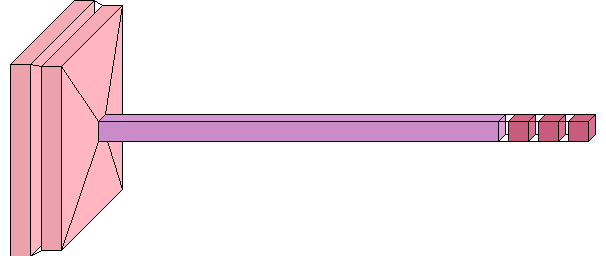

In [12]:
visualkeras.layered_view(model, color_map=color_map)

In [36]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
flatten_2 (Flatten)          (None, 135424)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               17334400  
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 130       
Total params: 17,362,178
Trainable params: 17,362,178
Non-trainable params: 0
__________________________________________

using channel shift range + vertical and horizontal flips - *85,09 %* on testing set

In [16]:
STEP_SIZE_TRAIN=trainFlow.n//trainFlow.batch_size
STEP_SIZE_VALID=valFlow.n//valFlow.batch_size
history = model.fit(x=trainFlow,steps_per_epoch = STEP_SIZE_TRAIN, epochs=10,  validation_data=valFlow, validation_steps=STEP_SIZE_VALID)

Epoch 1/10
1772/1772 [==============================] - 161s 90ms/step - loss: 0.6061 - accuracy: 0.6625 - val_loss: 0.4925 - val_accuracy: 0.7632
Epoch 2/10
1772/1772 [==============================] - 160s 90ms/step - loss: 0.4884 - accuracy: 0.7749 - val_loss: 0.4959 - val_accuracy: 0.7642
Epoch 3/10
1772/1772 [==============================] - 158s 89ms/step - loss: 0.4523 - accuracy: 0.7992 - val_loss: 0.4127 - val_accuracy: 0.8220
Epoch 4/10
1772/1772 [==============================] - 159s 90ms/step - loss: 0.4306 - accuracy: 0.8094 - val_loss: 0.4558 - val_accuracy: 0.7945
Epoch 5/10
1772/1772 [==============================] - 159s 90ms/step - loss: 0.4246 - accuracy: 0.8124 - val_loss: 0.3964 - val_accuracy: 0.8304
Epoch 6/10
1772/1772 [==============================] - 159s 90ms/step - loss: 0.4118 - accuracy: 0.8183 - val_loss: 0.4362 - val_accuracy: 0.8143
Epoch 7/10
1772/1772 [==============================] - 158s 89ms/step - loss: 0.3994 - accuracy: 0.8269 - val_loss: 0

In [63]:
results_model = model.evaluate(testFlow)

247/247 [==============================] - 10s 42ms/step - loss: 0.3541 - accuracy: 0.8509


using 90 degrees rotation and ZCA whitening  - *84,73 %* on testing set

In [19]:
STEP_SIZE_TRAIN=train_generator_w.n//train_generator_w.batch_size
STEP_SIZE_VALID=val_generator_w.n//val_generator_w.batch_size
history3 = model.fit(x=train_generator_w,steps_per_epoch = STEP_SIZE_TRAIN, epochs=10,  validation_data=val_generator_w, validation_steps=STEP_SIZE_VALID)

Epoch 1/10
1772/1772 [==============================] - 161s 90ms/step - loss: 0.6030 - accuracy: 0.6645 - val_loss: 0.4498 - val_accuracy: 0.8084
Epoch 2/10
1772/1772 [==============================] - 159s 90ms/step - loss: 0.4634 - accuracy: 0.7906 - val_loss: 0.4315 - val_accuracy: 0.8103
Epoch 3/10
1772/1772 [==============================] - 159s 90ms/step - loss: 0.4335 - accuracy: 0.8073 - val_loss: 0.4032 - val_accuracy: 0.8254
Epoch 4/10
1772/1772 [==============================] - 159s 90ms/step - loss: 0.4162 - accuracy: 0.8174 - val_loss: 0.3986 - val_accuracy: 0.8271
Epoch 5/10
1772/1772 [==============================] - 158s 89ms/step - loss: 0.4085 - accuracy: 0.8217 - val_loss: 0.3964 - val_accuracy: 0.8282
Epoch 6/10
1772/1772 [==============================] - 158s 89ms/step - loss: 0.3968 - accuracy: 0.8274 - val_loss: 0.3849 - val_accuracy: 0.8354
Epoch 7/10
1772/1772 [==============================] - 165s 93ms/step - loss: 0.3891 - accuracy: 0.8317 - val_loss: 0

In [20]:
results_model_w = model.evaluate(testFlow)

247/247 [==============================] - 10s 38ms/step - loss: 0.3573 - accuracy: 0.8473


using 90 degrees rotation - *84,60%*

In [22]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=val_generator.n//val_generator.batch_size
history4 = model.fit(x=train_generator,steps_per_epoch = STEP_SIZE_TRAIN, epochs=10,  validation_data=val_generator, validation_steps=STEP_SIZE_VALID)

Epoch 1/10
1772/1772 [==============================] - 164s 93ms/step - loss: 0.5978 - accuracy: 0.6760 - val_loss: 0.4548 - val_accuracy: 0.7947
Epoch 2/10
1772/1772 [==============================] - 158s 89ms/step - loss: 0.4690 - accuracy: 0.7873 - val_loss: 0.4268 - val_accuracy: 0.8113
Epoch 3/10
1772/1772 [==============================] - 158s 89ms/step - loss: 0.4393 - accuracy: 0.8015 - val_loss: 0.4168 - val_accuracy: 0.8171
Epoch 4/10
1772/1772 [==============================] - 159s 90ms/step - loss: 0.4238 - accuracy: 0.8116 - val_loss: 0.4035 - val_accuracy: 0.8230
Epoch 5/10
1772/1772 [==============================] - 158s 89ms/step - loss: 0.4112 - accuracy: 0.8200 - val_loss: 0.4182 - val_accuracy: 0.8168
Epoch 6/10
1772/1772 [==============================] - 158s 89ms/step - loss: 0.3999 - accuracy: 0.8245 - val_loss: 0.3944 - val_accuracy: 0.8313
Epoch 7/10
1772/1772 [==============================] - 169s 95ms/step - loss: 0.3934 - accuracy: 0.8300 - val_loss: 0

In [23]:
results_model_ = model.evaluate(testFlow)

247/247 [==============================] - 11s 44ms/step - loss: 0.3556 - accuracy: 0.8460


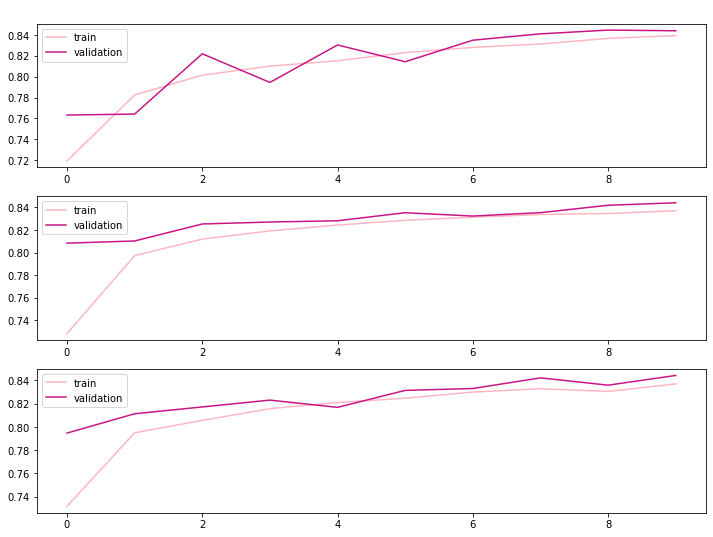

In [24]:
plt.figure(figsize = (12,9))

plt.subplot(3,1,1)
plt.plot(history.history['accuracy'], label="train_accuracy",color='lightpink')
plt.plot(history.history['val_accuracy'], label = "test_accuracy",color='mediumvioletred')
title = plt.title('Model accuracy with horizontal and vertical flips and channel shiftrange')
plt.legend(['train', 'validation'], loc='upper left')
plt.setp(title, fontsize=14,color=(0,0,0,0)) 

plt.subplot(3,1,2)
plt.plot(history3.history['accuracy'], label="train_accuracy",color='lightpink')
plt.plot(history3.history['val_accuracy'], label = "test_accuracy",color='mediumvioletred')
title = plt.title('Model accuracy with ZCA whitening')
plt.legend(['train', 'validation'], loc='upper left')
plt.setp(title, fontsize=14,color=(0,0,0,0)) 

plt.subplot(3,1,3)
plt.plot(history4.history['accuracy'], label="train_accuracy",color='lightpink')
plt.plot(history4.history['val_accuracy'], label = "test_accuracy",color='mediumvioletred')
title = plt.title('Model accuracy with 90° rotation')
plt.legend(['train', 'validation'], loc='upper left')
plt.setp(title, fontsize=14,color=(0,0,0,0)) 


plt.savefig('results/model_all_data_aug2.png',transparent=True)
plt.show()

*Only using the first data generator with channel shift range*

In [65]:
#Confusion Matrix and Classification Report
Y_pred = model.predict(testFlow)
y_pred = np.argmax(Y_pred, axis=1)

print('Classification Report')
target_names = ['IDC+', 'IDC-']
print(classification_report(testFlow.classes, y_pred, target_names=target_names))
#https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045

Classification Report
              precision    recall  f1-score   support

        IDC+       0.87      0.82      0.85      7855
        IDC-       0.83      0.88      0.86      7903

    accuracy                           0.85     15758
   macro avg       0.85      0.85      0.85     15758
weighted avg       0.85      0.85      0.85     15758



Normalized confusion matrix


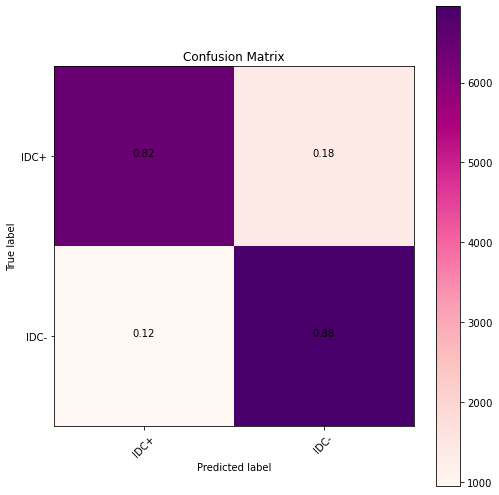

In [77]:
#Confusion Matrix 
cm = confusion_matrix(testFlow.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')


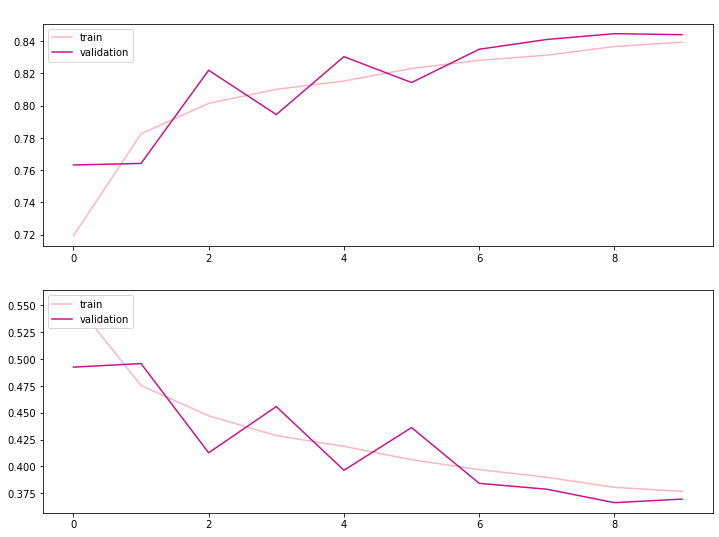

In [26]:
plt.figure(figsize = (12,9))
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'], label="train_accuracy",color='lightpink')
plt.plot(history.history['val_accuracy'], label = "test_accuracy",color='mediumvioletred')
title = plt.title('Model accuracy')
plt.legend(['train', 'validation'], loc='upper left')
plt.setp(title, fontsize=14,color=(1,1,1,1)) 
plt.subplot(2,1,2)
plt.plot(history.history['loss'], label = "train_loss",color='lightpink')
plt.plot(history.history['val_loss'], label = "val_loss",color='mediumvioletred')
title = plt.title('Model loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.setp(title, fontsize=14,color=(1,1,1,1)) 
plt.savefig('results/model_results.png',transparent=True)
plt.show()

Second model a bit more complex with the same data generator 84,18%

In [27]:
model2 = Sequential()
model2.add(Conv2D(32,kernel_size=3,activation='relu',input_shape=(50,50,3)))
model2.add(Conv2D(64,kernel_size=3,activation='relu'))
model2.add(Conv2D(128,kernel_size=6,activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Flatten())
model2.add(Dense(128,activation="relu"))
model2.add(Dense(64,activation="relu"))
model2.add(Dense(2, activation='softmax'))
model2.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])

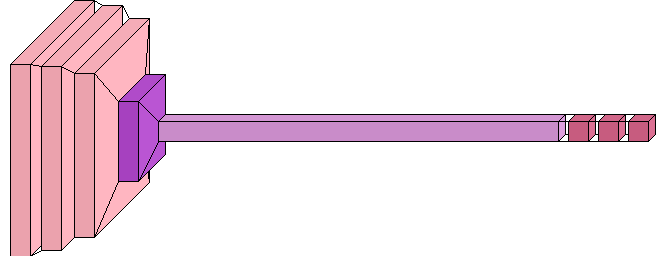

In [22]:
visualkeras.layered_view(model2, color_map=color_map)

In [37]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 41, 41, 128)       295040    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 20, 128)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               6553728   
_________________________________________________________________
dense_10 (Dense)             (None, 64)               

In [28]:
STEP_SIZE_TRAIN=trainFlow.n//trainFlow.batch_size
STEP_SIZE_VALID=valFlow.n//valFlow.batch_size
history2 = model2.fit(x=trainFlow,steps_per_epoch = STEP_SIZE_TRAIN, epochs=10,  validation_data=valFlow, validation_steps=STEP_SIZE_VALID)

Epoch 1/10
1772/1772 [==============================] - 594s 334ms/step - loss: 0.6042 - accuracy: 0.6752 - val_loss: 0.4812 - val_accuracy: 0.7851
Epoch 2/10
1772/1772 [==============================] - 596s 336ms/step - loss: 0.4765 - accuracy: 0.7820 - val_loss: 0.4374 - val_accuracy: 0.8127
Epoch 3/10
1772/1772 [==============================] - 593s 334ms/step - loss: 0.4290 - accuracy: 0.8099 - val_loss: 0.4026 - val_accuracy: 0.8268
Epoch 4/10
1772/1772 [==============================] - 596s 336ms/step - loss: 0.4052 - accuracy: 0.8262 - val_loss: 0.4297 - val_accuracy: 0.8078
Epoch 5/10
1772/1772 [==============================] - 634s 358ms/step - loss: 0.3991 - accuracy: 0.8269 - val_loss: 0.4027 - val_accuracy: 0.8266
Epoch 6/10
1772/1772 [==============================] - 632s 357ms/step - loss: 0.3878 - accuracy: 0.8325 - val_loss: 0.3696 - val_accuracy: 0.8434
Epoch 7/10
1772/1772 [==============================] - 641s 362ms/step - loss: 0.3805 - accuracy: 0.8378 - val_

In [29]:
results_model2 = model2.evaluate(testFlow)

247/247 [==============================] - 30s 119ms/step - loss: 0.3523 - accuracy: 0.8502


In [30]:
Y_pred2 = model2.predict(testFlow)
y_pred2 = np.argmax(Y_pred2, axis=1)

print('Classification Report')
target_names = ['IDC+', 'IDC-']
print(classification_report(testFlow.classes, y_pred2, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

        IDC+       0.86      0.84      0.85      7910
        IDC-       0.84      0.86      0.85      7848

    accuracy                           0.85     15758
   macro avg       0.85      0.85      0.85     15758
weighted avg       0.85      0.85      0.85     15758



Normalized confusion matrix


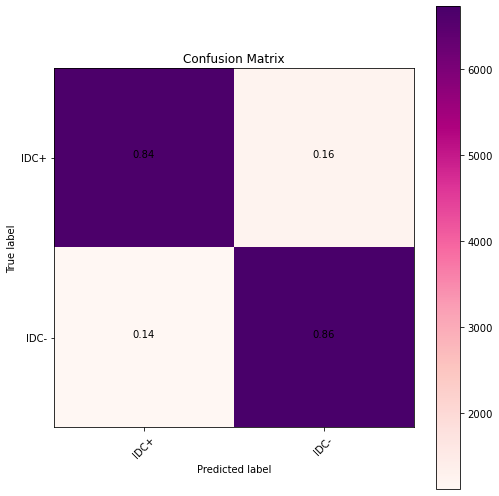

In [33]:
cm2 = confusion_matrix(testFlow.classes, y_pred2)
plot_confusion_matrix(cm2, target_names, title='Confusion Matrix')

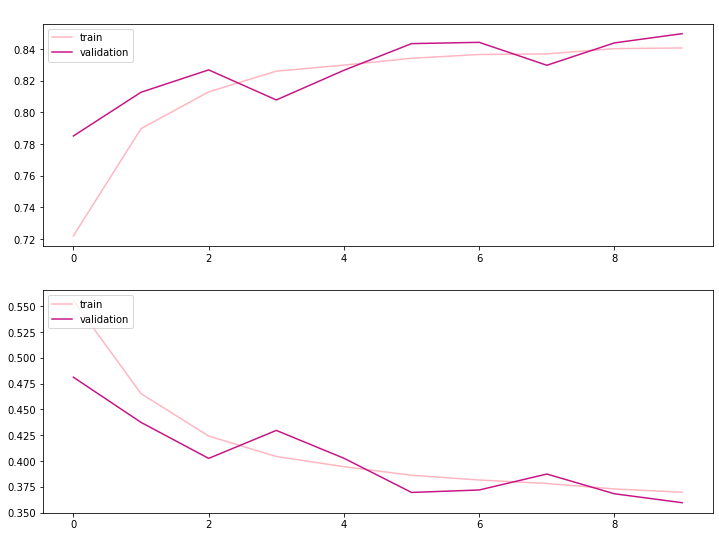

In [34]:
plt.figure(figsize = (12,9))
plt.subplot(2,1,1)
plt.plot(history2.history['accuracy'], label="train_accuracy",color='lightpink')
plt.plot(history2.history['val_accuracy'], label = "test_accuracy",color='mediumvioletred')
title = plt.title('Model2 accuracy')
plt.legend(['train', 'validation'], loc='upper left')
plt.setp(title, fontsize=14,color=(1,1,1,1)) 
plt.subplot(2,1,2)
plt.plot(history2.history['loss'], label = "train_loss",color='lightpink')
plt.plot(history2.history['val_loss'], label = "val_loss",color='mediumvioletred')
title = plt.title('Model2 loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.setp(title, fontsize=14,color=(1,1,1,1)) 
plt.savefig('results/model2_results.png',transparent=True)
plt.show()

## Models 

This section contains two models previously described in scientific papers : AggNet and AlexNet

### AggNet

*86,17%*

In [48]:
AggNet = Sequential()
AggNet.add(Conv2D(16, (3, 3), padding='same'))
AggNet.add(BatchNormalization())
AggNet.add(Activation('relu'))
AggNet.add(MaxPooling2D(pool_size=(2, 2)))

AggNet.add(Conv2D(32, (3, 3), padding='same'))
AggNet.add(BatchNormalization())
AggNet.add(Activation('relu'))
AggNet.add(MaxPooling2D(pool_size=(2, 2)))
AggNet.add(Conv2D(32, (3, 3), padding='same'))
AggNet.add(BatchNormalization())
AggNet.add(Activation('relu'))
AggNet.add(MaxPooling2D(pool_size=(2, 2)))

AggNet.add(Flatten())
AggNet.add(Dense(100))
AggNet.add(Activation('relu'))
AggNet.add(Dropout(0.3))
AggNet.add(Dense(2))
AggNet.add(Activation('softmax'))
optimizer = Adam(0.001, 0.9, 0.999, None)
AggNet.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

#source code : https://github.com/HiYellowC/AggNet/blob/master/model.py

In [84]:
STEP_SIZE_TRAIN=trainFlow.n//trainFlow.batch_size
STEP_SIZE_VALID=valFlow.n//valFlow.batch_size
history_agg = AggNet.fit(x=trainFlow,steps_per_epoch = STEP_SIZE_TRAIN, epochs=20,  validation_data=valFlow, validation_steps=STEP_SIZE_VALID)

Epoch 1/20
1772/1772 [==============================] - 86s 48ms/step - loss: 0.5205 - accuracy: 0.7769 - val_loss: 0.5746 - val_accuracy: 0.7401
Epoch 2/20
1772/1772 [==============================] - 89s 50ms/step - loss: 0.4138 - accuracy: 0.8268 - val_loss: 0.3678 - val_accuracy: 0.8438
Epoch 3/20
1772/1772 [==============================] - 81s 46ms/step - loss: 0.4011 - accuracy: 0.8346 - val_loss: 0.6561 - val_accuracy: 0.7087
Epoch 4/20
1772/1772 [==============================] - 92s 52ms/step - loss: 0.3846 - accuracy: 0.8402 - val_loss: 0.3888 - val_accuracy: 0.8271
Epoch 5/20
1772/1772 [==============================] - 85s 48ms/step - loss: 0.3695 - accuracy: 0.8481 - val_loss: 0.7056 - val_accuracy: 0.6430
Epoch 6/20
1772/1772 [==============================] - 82s 46ms/step - loss: 0.3670 - accuracy: 0.8493 - val_loss: 0.4552 - val_accuracy: 0.7792
Epoch 7/20
1772/1772 [==============================] - 104s 59ms/step - loss: 0.3583 - accuracy: 0.8527 - val_loss: 0.3698 

In [86]:
print("Evaluate on testing set")
results_agg = AggNet.evaluate(testFlow)
print("test loss, test acc:", results_agg)

Evaluate on testing set
247/247 [==============================] - 5s 21ms/step - loss: 0.3429 - accuracy: 0.8617
test loss, test acc: [0.3428678810596466, 0.8617210388183594]


In [87]:
Y_pred_agg = AggNet.predict(testFlow)
y_pred_agg = np.argmax(Y_pred_agg, axis=1)

print('Classification Report')
target_names = ['IDC+', 'IDC-']
print(classification_report(testFlow.classes, y_pred_agg, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

        IDC+       0.84      0.89      0.87      7855
        IDC-       0.89      0.83      0.86      7903

    accuracy                           0.86     15758
   macro avg       0.86      0.86      0.86     15758
weighted avg       0.86      0.86      0.86     15758



In [38]:
cm_agg = confusion_matrix(testFlow.classes, y_pred_agg)
plot_confusion_matrix(cm_agg, target_names, title='Confusion Matrix')

NameError: name 'y_pred_agg' is not defined

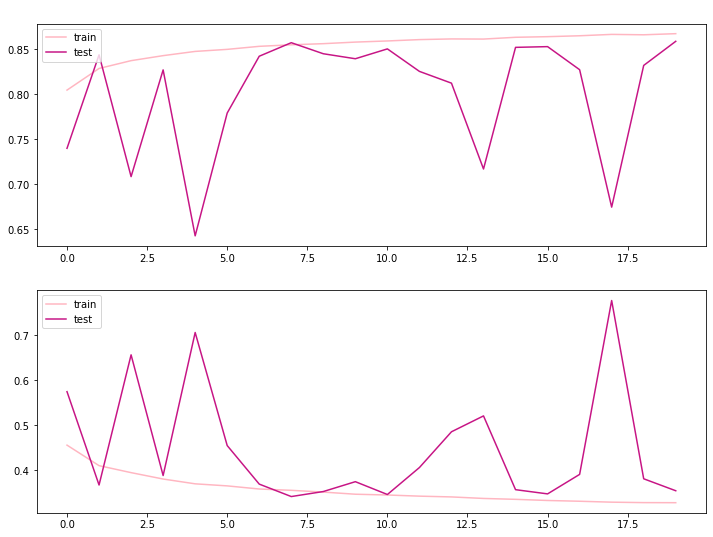

In [89]:
plt.figure(figsize = (12,9))
plt.subplot(2,1,1)
plt.plot(history_agg.history['accuracy'], label="train_accuracy",color='lightpink')
plt.plot(history_agg.history['val_accuracy'], label = "test_accuracy",color='mediumvioletred')
title = plt.title('AggNet accuracy')
plt.legend(['train', 'validation'], loc='upper left')
plt.setp(title, fontsize=14,color=(1,1,1,1)) 
plt.subplot(2,1,2)
plt.plot(history_agg.history['loss'], label = "train_loss",color='lightpink')
plt.plot(history_agg.history['val_loss'], label = "val_loss",color='mediumvioletred')
title = plt.title('AggNet loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.setp(title, fontsize=14,color=(1,1,1,1)) 
plt.savefig('results/AggNet_results_channelshift20epochs.png',transparent=True)
plt.show()

In [199]:
STEP_SIZE_TRAIN=train_generator_t.n//train_generator_t.batch_size
STEP_SIZE_VALID=val_generator_t.n//val_generator_t.batch_size
history_agg = AggNet.fit(x=train_generator,steps_per_epoch = STEP_SIZE_TRAIN, epochs=20,  validation_data=val_generator_t, validation_steps=STEP_SIZE_VALID)

Epoch 1/20
1772/1772 [==============================] - 104s 59ms/step - loss: 0.3084 - accuracy: 0.8724 - val_loss: 0.4733 - val_accuracy: 0.8285
Epoch 2/20
1772/1772 [==============================] - 96s 54ms/step - loss: 0.3096 - accuracy: 0.8738 - val_loss: 0.5096 - val_accuracy: 0.7382
Epoch 3/20
1772/1772 [==============================] - 103s 58ms/step - loss: 0.3080 - accuracy: 0.8733 - val_loss: 1.0953 - val_accuracy: 0.5823
Epoch 4/20
1772/1772 [==============================] - 96s 54ms/step - loss: 0.3058 - accuracy: 0.8749 - val_loss: 0.4055 - val_accuracy: 0.8159
Epoch 5/20
1772/1772 [==============================] - 91s 51ms/step - loss: 0.3052 - accuracy: 0.8754 - val_loss: 0.4635 - val_accuracy: 0.8108
Epoch 6/20
1772/1772 [==============================] - 96s 54ms/step - loss: 0.3052 - accuracy: 0.8750 - val_loss: 0.4627 - val_accuracy: 0.7935
Epoch 7/20
1772/1772 [==============================] - 92s 52ms/step - loss: 0.3042 - accuracy: 0.8748 - val_loss: 0.3571

In [200]:
print("Evaluate on testing set")
results = AggNet.evaluate(test_generator_t)
print("test loss, test acc:", results)

Evaluate on testing set
247/247 [==============================] - 7s 28ms/step - loss: 0.8814 - accuracy: 0.7201
test loss, test acc: [0.8813522458076477, 0.720078706741333]


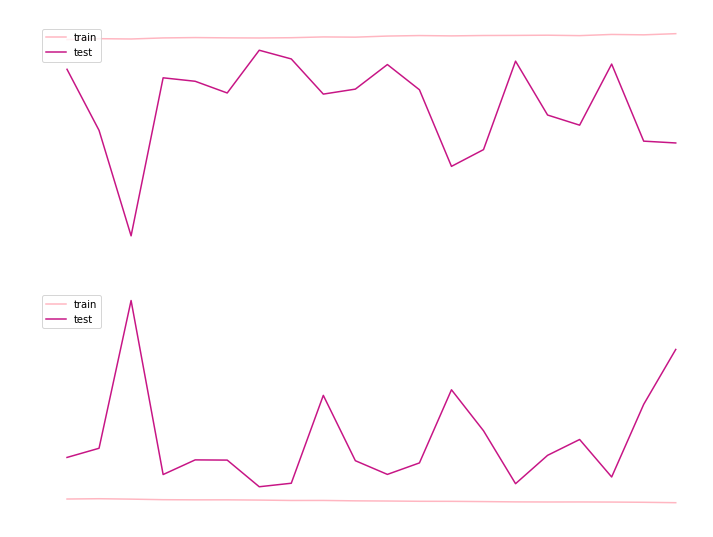

In [201]:
plt.figure(figsize = (12,9))
plt.subplot(2,1,1)
plt.plot(history_agg.history['accuracy'], label="train_accuracy",color='lightpink')
plt.plot(history_agg.history['val_accuracy'], label = "test_accuracy",color='mediumvioletred')
title = plt.title('AggNet accuracy')
plt.legend(['train', 'validation'], loc='upper left')
plt.setp(title, fontsize=14,color=(1,1,1,1)) 
plt.subplot(2,1,2)
plt.plot(history_agg.history['loss'], label = "train_loss",color='lightpink')
plt.plot(history_agg.history['val_loss'], label = "val_loss",color='mediumvioletred')
title = plt.title('AggNet loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.setp(title, fontsize=14,color=(1,1,1,1)) 
plt.savefig('results/AggNet_results_rotationandAHE20epochs.png',transparent=True)
plt.show()

### AlexNet

*82,88%*

In [91]:
#Instantiation
AlexNet = Sequential()

#1st Convolutional Layer
AlexNet.add(Conv2D(filters=96, kernel_size=(5,5), strides=1, padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
AlexNet.add(Activation('relu'))

#2nd Convolutional Layer
AlexNet.add(Conv2D(filters=128, kernel_size=(5,5), strides=1,padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'))

AlexNet.add(Dropout(0.25))

#3rd Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same'))
AlexNet.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#4th Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same'))
#AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

AlexNet.add(Dropout(0.2))

#5th Convolutional Layer
AlexNet.add(Conv2D(filters=128, kernel_size=(5,5), strides=(1,1), padding='same'))
#AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'))


#Passing it to a Fully Connected layer
AlexNet.add(Flatten())
# 1st Fully Connected Layer
#AlexNet.add(Dense(4096))
#AlexNet.add(BatchNormalization())
#AlexNet.add(Activation('relu'))
# Add Dropout to prevent overfitting
#AlexNet.add(Dropout(0.4))

#2nd Fully Connected Layer
AlexNet.add(Dense(512))
#AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.2))

#3rd Fully Connected Layer
#AlexNet.add(Dense(1000,activation='relu'))
#AlexNet.add(BatchNormalization())
#AlexNet.add(Activation('relu'))
#Add Dropout
#AlexNet.add(Dropout(0.4))
AlexNet.add(Flatten())
#Output Layer

AlexNet.add(Dense(2,activation='softmax'))
#AlexNet.add(BatchNormalization())
#AlexNet.add(Activation('softmax'))
AlexNet.compile(loss = keras.losses.categorical_crossentropy, optimizer= 'sgd', metrics=['accuracy'])

In [94]:
STEP_SIZE_TRAIN=trainFlow.n//trainFlow.batch_size
STEP_SIZE_VALID=valFlow.n//valFlow.batch_size
history_alex = AlexNet.fit(x=trainFlow,steps_per_epoch = STEP_SIZE_TRAIN, epochs=10,  validation_data=valFlow, validation_steps=STEP_SIZE_VALID)

Epoch 1/10
1772/1772 [==============================] - 512s 289ms/step - loss: 0.4551 - accuracy: 0.7969 - val_loss: 0.4397 - val_accuracy: 0.8123
Epoch 2/10
1772/1772 [==============================] - 506s 285ms/step - loss: 0.4139 - accuracy: 0.8188 - val_loss: 0.4685 - val_accuracy: 0.7822
Epoch 3/10
1772/1772 [==============================] - 524s 295ms/step - loss: 0.3971 - accuracy: 0.8296 - val_loss: 0.3942 - val_accuracy: 0.8359
Epoch 4/10
1772/1772 [==============================] - 509s 287ms/step - loss: 0.3872 - accuracy: 0.8334 - val_loss: 0.4651 - val_accuracy: 0.7875
Epoch 5/10
1772/1772 [==============================] - 497s 280ms/step - loss: 0.3785 - accuracy: 0.8390 - val_loss: 0.5345 - val_accuracy: 0.7316
Epoch 6/10
1772/1772 [==============================] - 514s 290ms/step - loss: 0.3730 - accuracy: 0.8413 - val_loss: 0.4620 - val_accuracy: 0.7950
Epoch 7/10
1772/1772 [==============================] - 509s 287ms/step - loss: 0.3690 - accuracy: 0.8437 - val_

In [96]:
print("Evaluate on testing set")
results_alex = AlexNet.evaluate(testFlow)
print("test loss, test acc:", results_alex)

Evaluate on testing set
247/247 [==============================] - 23s 90ms/step - loss: 0.3855 - accuracy: 0.8353
test loss, test acc: [0.3855178654193878, 0.8352583050727844]


In [85]:
Y_pred_alex = AlexNet.predict(testFlow)
y_pred_alex = np.argmax(Y_pred_alex, axis=1)

print('Classification Report')
target_names = ['IDC+', 'IDC-']
print(classification_report(testFlow.classes, y_pred_alex, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

        IDC+       0.95      0.44      0.61      7830
        IDC-       0.64      0.98      0.77      7928

    accuracy                           0.71     15758
   macro avg       0.80      0.71      0.69     15758
weighted avg       0.80      0.71      0.69     15758



Normalized confusion matrix


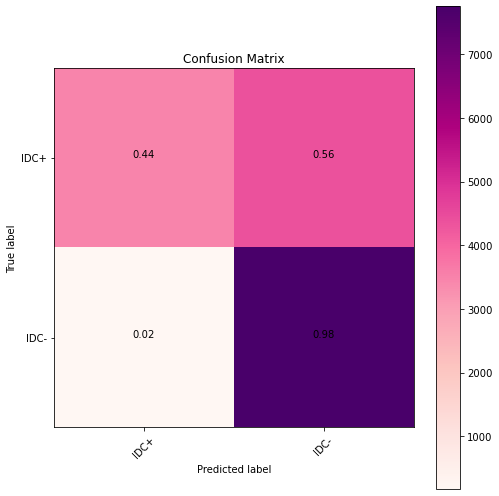

In [88]:
cm_alex = confusion_matrix(testFlow.classes, y_pred_alex)
plot_confusion_matrix(cm_alex, target_names, title='Confusion Matrix')

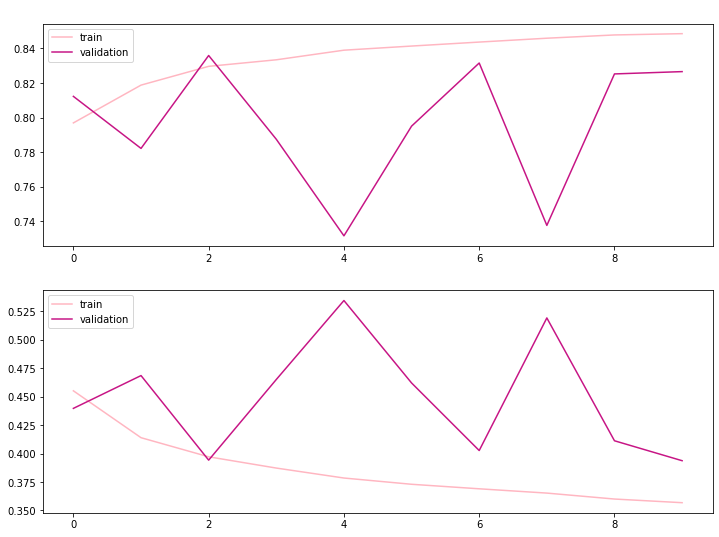

In [97]:
plt.figure(figsize = (12,9))
plt.subplot(2,1,1)
plt.plot(history_alex.history['accuracy'], label="train_accuracy",color='lightpink')
plt.plot(history_alex.history['val_accuracy'], label = "test_accuracy",color='mediumvioletred')
title = plt.title('AlexNet accuracy')
plt.legend(['train', 'validation'], loc='upper left')
plt.setp(title, fontsize=14,color=(1,1,1,1)) 
plt.subplot(2,1,2)
plt.plot(history_alex.history['loss'], label = "train_loss",color='lightpink')
plt.plot(history_alex.history['val_loss'], label = "val_loss",color='mediumvioletred')
title = plt.title('AlexNet loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.setp(title, fontsize=14,color=(1,1,1,1)) 
plt.savefig('results/AlexNet_results_bis.png',transparent=True)
plt.show()

## Transfer Learning 

In this section 3 models of transfer learninf are used : ResNet50, DenseNet121 and VGG16

### ResNet50 

*83,08%*

In [43]:
base_model = ResNet50(input_shape=X_train.shape[1:],weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(2, activation='softmax')(x)


# this is the model we will train
model_resnet50 = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional ResNet50 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model_resnet50.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])

#model.summary()


In [13]:
STEP_SIZE_TRAIN=trainFlow.n//trainFlow.batch_size
STEP_SIZE_VALID=valFlow.n//valFlow.batch_size
history_resnet50 = model_resnet50.fit(x=trainFlow,steps_per_epoch = STEP_SIZE_TRAIN, epochs=10,  validation_data=valFlow, validation_steps=STEP_SIZE_VALID)

Epoch 1/10
1772/1772 [==============================] - 736s 415ms/step - loss: 0.5541 - accuracy: 0.7938 - val_loss: 0.4249 - val_accuracy: 0.8199
Epoch 2/10
1772/1772 [==============================] - 735s 415ms/step - loss: 0.4182 - accuracy: 0.8216 - val_loss: 0.4124 - val_accuracy: 0.8241
Epoch 3/10
1772/1772 [==============================] - 742s 419ms/step - loss: 0.4178 - accuracy: 0.8228 - val_loss: 0.4209 - val_accuracy: 0.8200
Epoch 4/10
1772/1772 [==============================] - 745s 421ms/step - loss: 0.4113 - accuracy: 0.8249 - val_loss: 0.4150 - val_accuracy: 0.8341
Epoch 5/10
1772/1772 [==============================] - 749s 423ms/step - loss: 0.4107 - accuracy: 0.8246 - val_loss: 0.4306 - val_accuracy: 0.8244
Epoch 6/10
1772/1772 [==============================] - 750s 423ms/step - loss: 0.4108 - accuracy: 0.8266 - val_loss: 0.4448 - val_accuracy: 0.8095
Epoch 7/10
1772/1772 [==============================] - 747s 421ms/step - loss: 0.4103 - accuracy: 0.8270 - val_

In [14]:
print("Evaluate on test data")
results_resnet50 = model_resnet50.evaluate(testFlow)
print("test loss, test acc:", results_resnet50)

Evaluate on test data
247/247 [==============================] - 82s 328ms/step - loss: 0.4091 - accuracy: 0.8308
test loss, test acc: [0.4090529978275299, 0.8308160901069641]


In [15]:
Y_pred_res = model_resnet50.predict(testFlow)
y_pred_res = np.argmax(Y_pred_res, axis=1)

print('Classification Report')
target_names = ['IDC+', 'IDC-']
print(classification_report(testFlow.classes, y_pred_res, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

        IDC+       0.81      0.86      0.84      7915
        IDC-       0.85      0.80      0.82      7843

    accuracy                           0.83     15758
   macro avg       0.83      0.83      0.83     15758
weighted avg       0.83      0.83      0.83     15758



Normalized confusion matrix


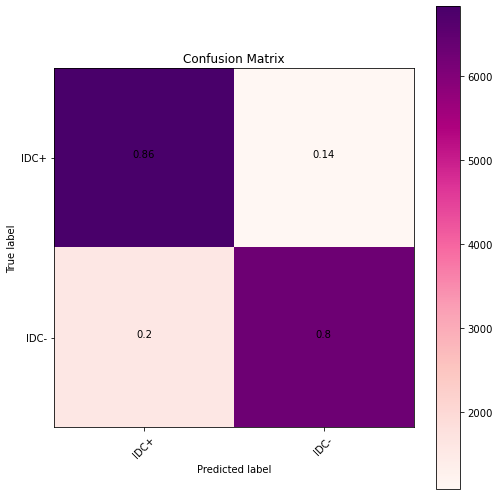

In [16]:
cm_resnet = confusion_matrix(testFlow.classes, y_pred_res)
plot_confusion_matrix(cm_resnet, target_names, title='Confusion Matrix')

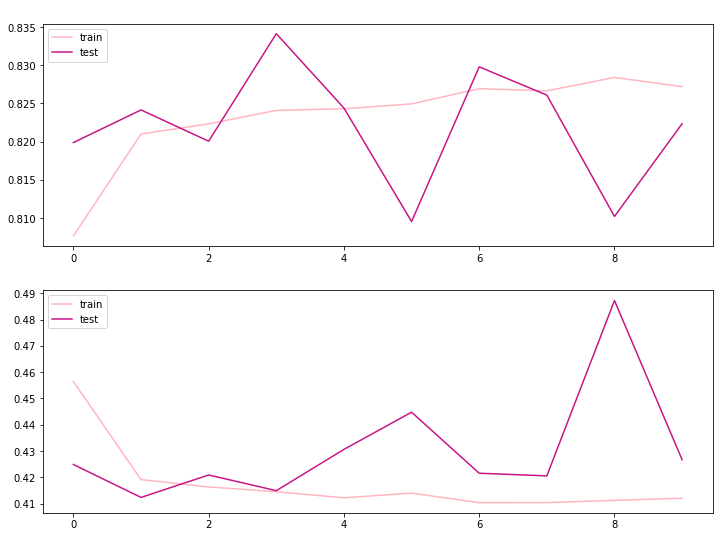

In [17]:
plt.figure(figsize = (12,9))
plt.subplot(2,1,1)
plt.plot(history_resnet50.history['accuracy'], label="train_accuracy",color='lightpink')
plt.plot(history_resnet50.history['val_accuracy'], label = "test_accuracy",color='mediumvioletred')
title = plt.title('Transfer Learning - ResNet50 accuracy')
plt.legend(['train', 'validation'], loc='upper left')
plt.setp(title, fontsize=14,color=(1,1,1,1)) 
plt.subplot(2,1,2)
plt.plot(history_resnet50.history['loss'], label = "train_loss",color='lightpink')
plt.plot(history_resnet50.history['val_loss'], label = "val_loss",color='mediumvioletred')
title = plt.title('Transfer Learning - ResNet50 loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.setp(title, fontsize=14,color=(1,1,1,1)) 
plt.savefig('results/resnet50_results_channelshift.png',transparent=True)
plt.show()

### VGG16 

*79,78%*

In [41]:
base_model2 = VGG16(input_shape=X_train.shape[1:],weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model2.output
x = GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(2, activation='softmax')(x)


# this is the model we will train
model_vgg16 = Model(inputs=base_model2.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional ResNet50 layers
for layer in base_model2.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model_vgg16.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])

#model.summary()

In [42]:
STEP_SIZE_TRAIN=trainFlow.n//trainFlow.batch_size
STEP_SIZE_VALID=valFlow.n//valFlow.batch_size



history_vgg16 = model_vgg16.fit(
    # set the generator to the train_data_generator
    x=trainFlow,
    # as a rule of thumb, you can use the total number of pictures in the train test and doing a floor division with the batch size
    steps_per_epoch=STEP_SIZE_TRAIN,
    epochs=10,
    # set the generator to the test_data_generator
    validation_data=valFlow,
    # same as above, but replace the train set by the test set
    validation_steps=STEP_SIZE_VALID
)


Epoch 1/10
1772/1772 [==============================] - 350s 197ms/step - loss: 0.5231 - accuracy: 0.7525 - val_loss: 0.4583 - val_accuracy: 0.7942
Epoch 2/10
1772/1772 [==============================] - 348s 196ms/step - loss: 0.4640 - accuracy: 0.7879 - val_loss: 0.4567 - val_accuracy: 0.7930
Epoch 3/10
1772/1772 [==============================] - 338s 191ms/step - loss: 0.4557 - accuracy: 0.7945 - val_loss: 0.4658 - val_accuracy: 0.7844
Epoch 4/10
1772/1772 [==============================] - 333s 188ms/step - loss: 0.4542 - accuracy: 0.7927 - val_loss: 0.4546 - val_accuracy: 0.7931
Epoch 5/10
1772/1772 [==============================] - 347s 196ms/step - loss: 0.4515 - accuracy: 0.7946 - val_loss: 0.4496 - val_accuracy: 0.7969
Epoch 6/10
1772/1772 [==============================] - 338s 191ms/step - loss: 0.4534 - accuracy: 0.7958 - val_loss: 0.4586 - val_accuracy: 0.7956
Epoch 7/10
1772/1772 [==============================] - 334s 188ms/step - loss: 0.4515 - accuracy: 0.7972 - val_

In [43]:
print("Evaluate on test data")
results_vgg16 = model_vgg16.evaluate(testFlow)
print("test loss, test acc:", results_vgg16)

Evaluate on test data
247/247 [==============================] - 39s 155ms/step - loss: 0.4507 - accuracy: 0.7978
test loss, test acc: [0.4507356584072113, 0.7977535128593445]


In [45]:
Y_pred_vgg = model_vgg16.predict(testFlow)
y_pred_vgg = np.argmax(Y_pred_vgg, axis=1)

print('Classification Report')
target_names = ['IDC+', 'IDC-']
print(classification_report(testFlow.classes, y_pred_vgg, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

        IDC+       0.80      0.80      0.80      7910
        IDC-       0.80      0.80      0.80      7848

    accuracy                           0.80     15758
   macro avg       0.80      0.80      0.80     15758
weighted avg       0.80      0.80      0.80     15758



Normalized confusion matrix


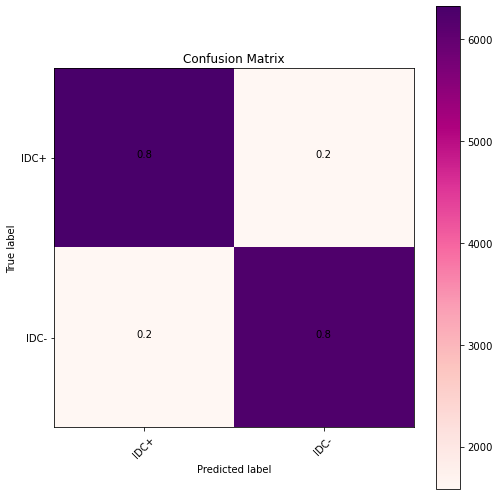

In [48]:
cm_vgg = confusion_matrix(testFlow.classes, y_pred_vgg)
plot_confusion_matrix(cm_vgg, target_names, title='Confusion Matrix')

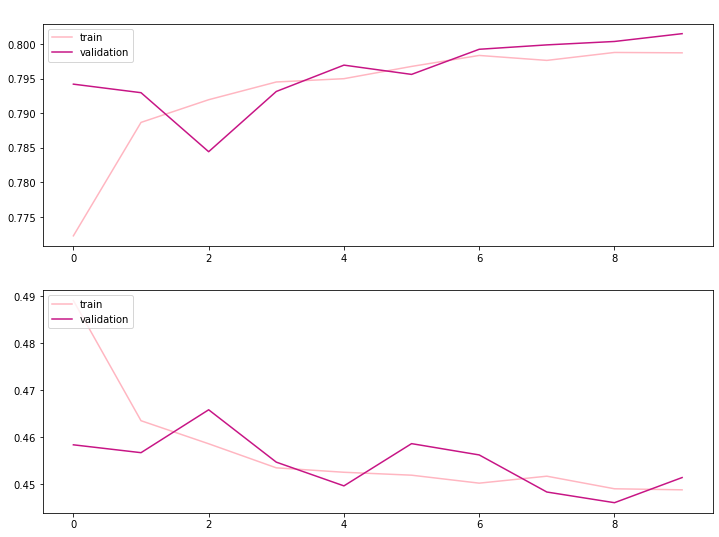

In [50]:
plt.figure(figsize = (12,9))
plt.subplot(2,1,1)
plt.plot(history_vgg16.history['accuracy'], label="train_accuracy",color='lightpink')
plt.plot(history_vgg16.history['val_accuracy'], label = "test_accuracy",color='mediumvioletred')
title = plt.title('Transfer Learning - VGG16 accuracy')
plt.legend(['train', 'validation'], loc='upper left')
plt.setp(title, fontsize=14,color=(1,1,1,1)) 
plt.subplot(2,1,2)
plt.plot(history_vgg16.history['loss'], label = "train_loss",color='lightpink')
plt.plot(history_vgg16.history['val_loss'], label = "val_loss",color='mediumvioletred')
title = plt.title('Transfer Learning - VGG16 loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.setp(title, fontsize=14,color=(1,1,1,1)) 
plt.savefig('results/vgg16_results.png',transparent=True)
plt.show()

### DenseNet121 

*79,4%*

In [46]:
base_model3 = DenseNet121(input_shape=X_train.shape[1:],weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model3.output
x = GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(2, activation='softmax')(x)


# this is the model we will train
model_dense = Model(inputs=base_model3.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional ResNet50 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model_dense.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])

#model.summary()

In [37]:
STEP_SIZE_TRAIN=trainFlow.n//trainFlow.batch_size
STEP_SIZE_VALID=valFlow.n//valFlow.batch_size



history_dense = model_dense.fit(
    # set the generator to the train_data_generator
    x=trainFlow,
    # as a rule of thumb, you can use the total number of pictures in the train test and doing a floor division with the batch size
    steps_per_epoch=STEP_SIZE_TRAIN,
    epochs=10,
    # set the generator to the test_data_generator
    validation_data=valFlow,
    # same as above, but replace the train set by the test set
    validation_steps=STEP_SIZE_VALID
)



Epoch 1/10
1772/1772 [==============================] - 570s 318ms/step - loss: 0.5294 - accuracy: 0.8021 - val_loss: 0.8828 - val_accuracy: 0.7435
Epoch 2/10
1772/1772 [==============================] - 1905s 1s/step - loss: 0.3643 - accuracy: 0.8484 - val_loss: 0.4329 - val_accuracy: 0.8195
Epoch 3/10
1772/1772 [==============================] - 565s 318ms/step - loss: 0.3447 - accuracy: 0.8556 - val_loss: 0.3629 - val_accuracy: 0.8489
Epoch 4/10
1772/1772 [==============================] - 595s 335ms/step - loss: 0.3381 - accuracy: 0.8603 - val_loss: 0.3836 - val_accuracy: 0.8467
Epoch 5/10
1772/1772 [==============================] - 606s 341ms/step - loss: 0.3249 - accuracy: 0.8662 - val_loss: 0.5451 - val_accuracy: 0.8133
Epoch 6/10
1772/1772 [==============================] - 584s 329ms/step - loss: 0.3197 - accuracy: 0.8676 - val_loss: 0.4451 - val_accuracy: 0.8266
Epoch 7/10
1772/1772 [==============================] - 626s 353ms/step - loss: 0.3154 - accuracy: 0.8685 - val_lo

In [38]:
print("Evaluate on test data")
results_dense = model_dense.evaluate(testFlow)
print("test loss, test acc:", results_dense)

Evaluate on test data
247/247 [==============================] - 23s 92ms/step - loss: 0.5602 - accuracy: 0.7940
test loss, test acc: [0.5601921677589417, 0.7940093874931335]


In [40]:
Y_pred_dense = model_dense.predict(testFlow)
y_pred_dense = np.argmax(Y_pred_dense, axis=1)

print('Classification Report')
target_names = ['IDC+', 'IDC-']
print(classification_report(testFlow.classes, y_pred_dense, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

        IDC+       0.73      0.95      0.82      7915
        IDC-       0.92      0.64      0.76      7843

    accuracy                           0.79     15758
   macro avg       0.82      0.79      0.79     15758
weighted avg       0.82      0.79      0.79     15758



Normalized confusion matrix


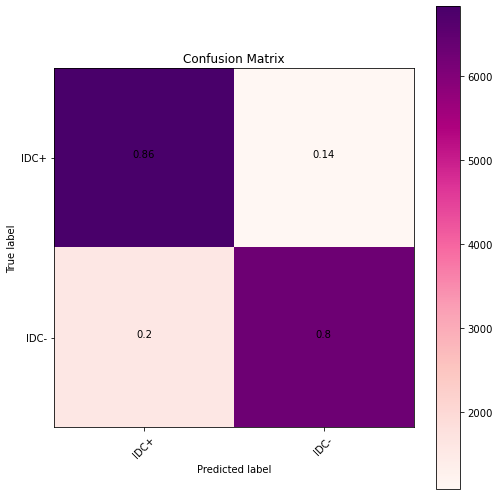

In [41]:
cm_dense = confusion_matrix(testFlow.classes, y_pred_res)
plot_confusion_matrix(cm_dense, target_names, title='Confusion Matrix')

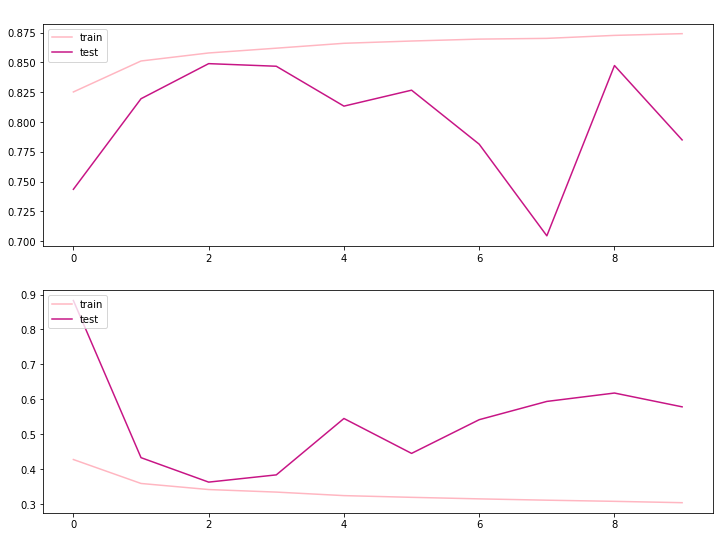

In [42]:
plt.figure(figsize = (12,9))
plt.subplot(2,1,1)
plt.plot(history_dense.history['accuracy'], label="train_accuracy",color='lightpink')
plt.plot(history_dense.history['val_accuracy'], label = "test_accuracy",color='mediumvioletred')
title = plt.title('Transfer Learning - DensetNet121 accuracy')
plt.legend(['train', 'validation'], loc='upper left')
plt.setp(title, fontsize=14,color=(1,1,1,1)) 
plt.subplot(2,1,2)
plt.plot(history_dense.history['loss'], label = "train_loss",color='lightpink')
plt.plot(history_dense.history['val_loss'], label = "val_loss",color='mediumvioletred')
title = plt.title('Transfer Learning - DenseNet121 loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.setp(title, fontsize=14,color=(1,1,1,1)) 
plt.savefig('results/densenet121_results_channelshift.png',transparent=True)
plt.show()